# TRUSTWORTHY AI: Privacy and Data governance Requirement

#### Script to ensure the Privacy and data governance requirement for a dataset. Based on EU guidelines.
<img src="../data/bdslab.png" width=400>
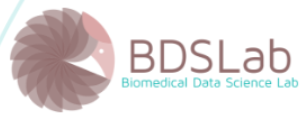


## TABLE OF CONTENTS:

<div class="alert" style="margin-top: 20px">

1. [Data preparation](#data-preparation)<br>
1.1. [Data pre-processing](#data-pre-processing)<br>
1.2. [Data quality control](#data-quality-control)

[References](#references)
</div>


The key requirement of Privacy and data governance covers four main concepts:

* **Privacy and data protection:** protect the information provided by the user and generated by the model. You must not use the data collected illegally or to discriminate unfairly.
*  **Quality and integrity of data:** ensure that data is free from bias and error.
*  **Acces to data:** consider data access protocols. Only qualified personnel should have access.


We start by preparing the working environment. Import all the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split

from pca import pca
import seaborn as sns
import math
import json
import prince
from dotenv import load_dotenv
from os import environ

In [2]:
# This is only to keep the notebook tidy
import warnings
warnings.filterwarnings('ignore')

Load the dataset and define Metadata

In [3]:
load_dotenv()
path = environ.get('DIABETES_DATASET')
file_name = 'dataset_simplified.csv'
data = pd.read_csv(path + file_name)

# Create a subset to work more efficiently
# data = data.sample(frac = 0.1, random_state = 1) 

In [4]:
# Load metadata from the JSON file
file_name = 'metadata.json'
with open(path + file_name, 'r') as json_file:
    metadata = json.load(json_file)

# Assign variables from loaded metadata
dataset = data
output = metadata["output"]
positive_class = metadata["positive_class"]

In [5]:
### Uncomment only if you want to binarise a multi-class classification problem ###
# if positive_class:
#     dataset[output] = pd.Series(np.where(dataset[output] == positive_class, 1, 0), index=dataset[output].index, name=output)

unique_classes = np.unique(dataset[output])
n_classes = len(unique_classes)
feat_num = [key for key, value in metadata["feat_types"].items() if value == "numerical"]
feat_cat = [key for key, value in metadata["feat_types"].items() if value == "categorical"]

## 1. DATA PREPARATION  <a class="anchor" id="data-preparation"></a>

### 1.1. Data Pre-processing: <a class="anchor" id="data-pre-processing"></a>

First, we must ensure that the data instances cannot be recognized (`Anonymization`). If you are working with sensitive data, it is important to consider data anonymization. There are various techniques available to ensure data privacy, including randomization or masking, as well as more specific methods such as k-anonymity [1].

In our dataset, two identifying features have been anonymized with individual numbers for each patient and encounter.  However, we do not need this information, so we will be working without these columns.

In [6]:
try:        
    dataset.drop(metadata["feat_id"], axis=1, inplace=True)
except KeyError:
    print("No identifying characteristics could be found.")

Furthermore, the information must follow a standard framework (`Standardisation`). Therefore, in our particular case we will convert the Diagnostic Code Description (ICD-9) in 'diag_1', 'diag_2' and 'diag_3' to their corresponding diagnosis [2, 3]. This is just an example of aggregation, standardization is handled by using these codes to identify the diagnosis.

In [7]:
# Define the categories and ranges to replace
categories = {
    'Circulatory': (390, 459),
    'Digestive': (520, 579),
    'Genitourinary': (580, 629),
    'Diabetes': (250),
    'Injury': (800, 999),
    'Musculoskeletal': (710, 739),
    'Neoplasms': (140, 239),
    'Respiratory': (460, 519),
    'Other': float('inf')  # Any other Value
}

# Function to replace the ICD-9 per the diagnosis
def replace_category(x, categories_dict):
    if pd.isna(x):
        return x

    try:
        for category, value_range in categories_dict.items():
            if pd.notna(x):
                if isinstance(value_range, int) and float(x) == value_range:
                    return category
                if (isinstance(value_range, tuple) and len(value_range) == 2 and 
                    value_range[0] <= float(x) <= value_range[1]):
                    return category
        return 'Other'
    except (ValueError, TypeError):  # 'except' to deal with V codes (V01-V82.9)
        return 'Other'

for col in ['diag_1', 'diag_2', 'diag_3']:
    dataset[col] = dataset[col].apply(lambda x: replace_category(x, categories))

At this stage, to make sure the model isn't biased, we split the data into a training set and a test set.

In [8]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, random_state = 1)

### 1.2. Data Quality Control: <a class="anchor" id="data-quality-control"></a>

During this stage, it is important to address the Data Quality Dimensions (`Data quality control`): completeness, consistency, correctness, uniqueness and stability [4]. Regarding completeness and correctness, technically, we address the existence of missing and outliers, respectively.

Outliers will be addressed using both univariate and multivariate methods. We will then address missing data. It may be helpful to consult the 'Data Provenance' to determine the type of missing data you are dealing with. 

First, it may be useful to set a threshold of missing values above which the feature is deleted, since without enough information the missing imputations are not real.

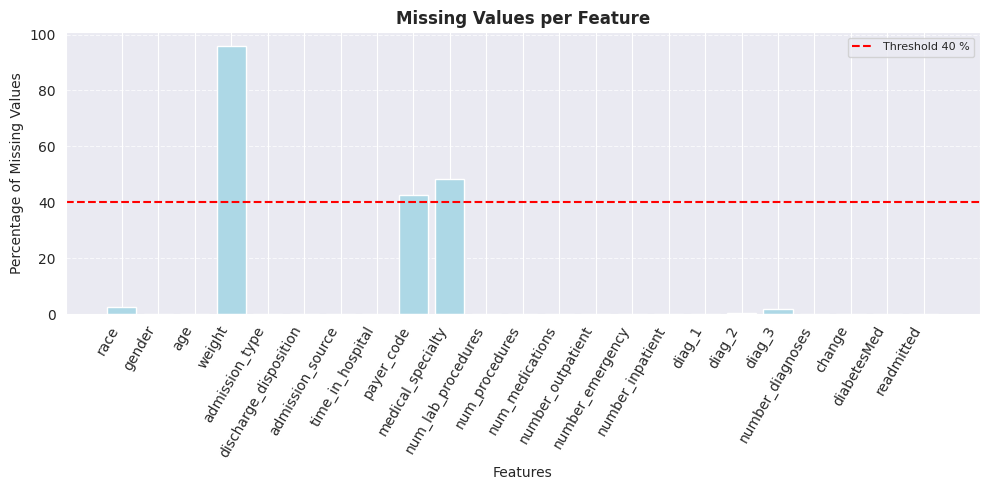

The following features have been removed: weight, payer_code, medical_specialty.


In [9]:
missing_threshold = 40 # Set an arbitrary threshold

# Calculate percentage of missings by column
# Here we also store the missing array to analyze possible biases
missing_array= dataset_train.isnull()
percentage_missing = missing_array.mean() * 100
missing_array[metadata['feat_sensitive']] = dataset_train[metadata['feat_sensitive']]
missing_array.to_csv(path + 'missing_array.csv', index=False)
table_missing = pd.DataFrame({'Feature': percentage_missing.index, 'Missing': percentage_missing.values})

plt.figure(figsize=(10, 5)) 
bars = plt.bar(table_missing['Feature'], table_missing['Missing'], color='lightblue')
plt.xticks(rotation=60, ha='right')
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.axhline(y=missing_threshold, color='red', linestyle='--', label=f'Threshold ({missing_threshold}%)')
plt.legend([f'Threshold {missing_threshold} %'], loc='upper right', title_fontsize='xx-small', prop={'size': 8})

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Missing Values per Feature', fontsize=12, weight='bold')
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percentage of Missing Values', fontsize=10)

plt.tight_layout()
plt.show()

# Delete columns with missings > missing_threshold
columns_delete = percentage_missing[percentage_missing > missing_threshold].index
print(f"The following features have been removed: {', '.join(columns_delete)}.")

dataset_train.drop(columns=columns_delete, inplace=True)
dataset_test.drop(columns=columns_delete, inplace=True)

for column in columns_delete:
    
    if column in metadata["feat_types"]:
        metadata["feat_types"].pop(column, None)  # None to avoid errors if the key does not exist

    if column in metadata["feat_sensitive"]:
        metadata["feat_sensitive"].pop(column, None) 


feat_num = [key for key, value in metadata["feat_types"].items() if value == "numerical"]
feat_cat = [key for key, value in metadata["feat_types"].items() if value == "categorical"]

Next, we resolve the outliers. To deal with categorical outliers, we set a frequency threshold for categorical features below which instances with that category are deleted.


Categories under the threshold in RACE

Categories under the threshold in GENDER
  Unknown/Invalid: 3 instances

Categories under the threshold in ADMISSION_TYPE

Categories under the threshold in DISCHARGE_DISPOSITION

Categories under the threshold in ADMISSION_SOURCE

Categories under the threshold in DIAG_1

Categories under the threshold in DIAG_2

Categories under the threshold in DIAG_3

Categories under the threshold in CHANGE

Categories under the threshold in DIABETESMED


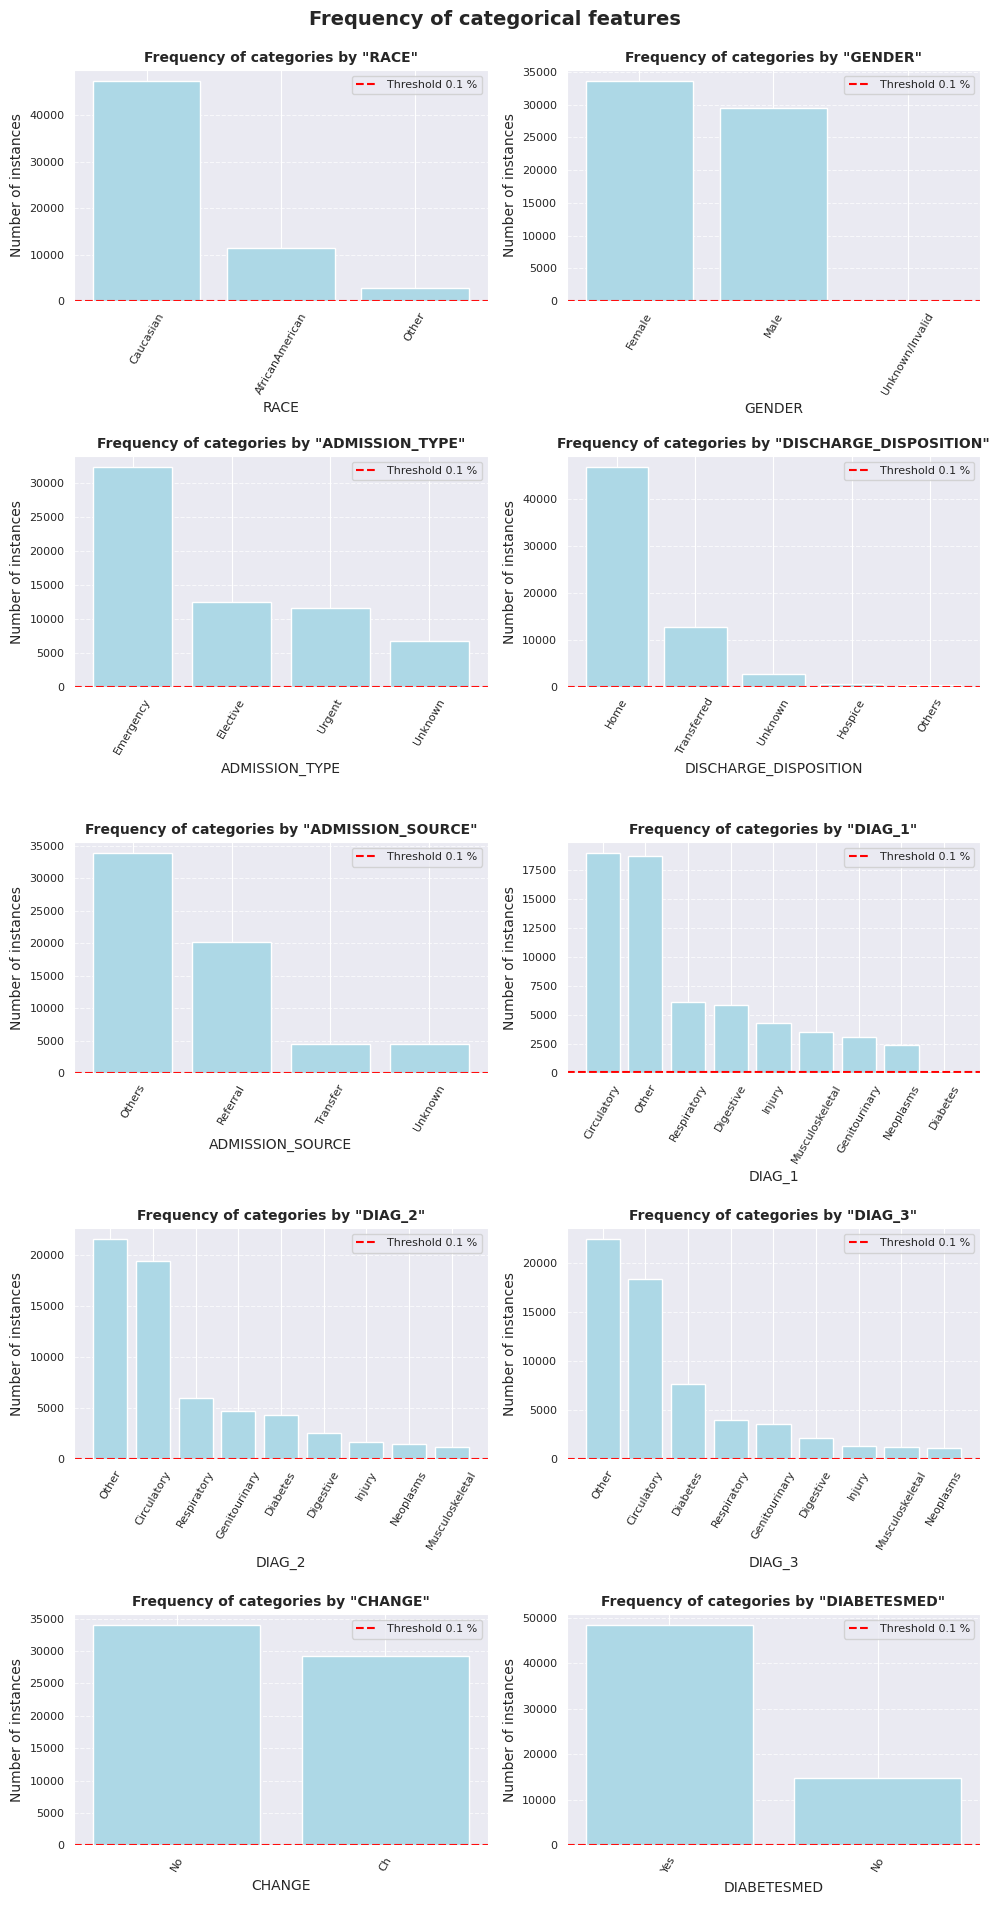

In [10]:
n_rows = math.ceil(len(feat_cat)/2)
percentage_outlier = 0.001 # Categories with less than 0.1% of the total instances will be deleted
threshold = percentage_outlier * len(dataset_train)  

fig, axes = plt.subplots(n_rows, 2, figsize=(10, 4 * n_rows))
fig.suptitle('Frequency of categorical features', fontsize=14, weight='bold')

if n_rows == 1:
    axes = axes.reshape(1, -1)  

for i, feat in enumerate(feat_cat):
    # Obtain tags and quantities
    feat_counts = dataset_train[feat].value_counts()
    unique_categories = feat_counts.index
    n_values = feat_counts.values

    print(f"\nCategories under the threshold in {feat.upper()}")
    for category, count in zip(unique_categories, n_values):
        if count < threshold:
            print(f"  {category}: {count} instances")
            dataset_train = dataset_train[~dataset_train[feat].isin([category])]
            dataset_test = dataset_test[~dataset_test[feat].isin([category])]            

    row = i // 2
    column = i % 2
    ax = axes[row, column]
    
    ax.bar(unique_categories, n_values, color='lightblue')
    ax.axhline(y=threshold, color='red', linestyle='--', linewidth=1.5, label='5% threshold')
    ax.set_xlabel(feat.upper(), fontsize=10)
    ax.set_ylabel(f'Number of instances', fontsize=10)
    ax.set_title(f'Frequency of categories by "{feat.upper()}"', fontsize=10, weight='bold')
    ax.tick_params(axis='x', labelrotation=60, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend([f'Threshold {percentage_outlier * 100} %'], loc='upper right', title_fontsize='xx-small', prop={'size': 8})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(top=0.95)
plt.show()


Now we deal with the numerical univariate outliers.

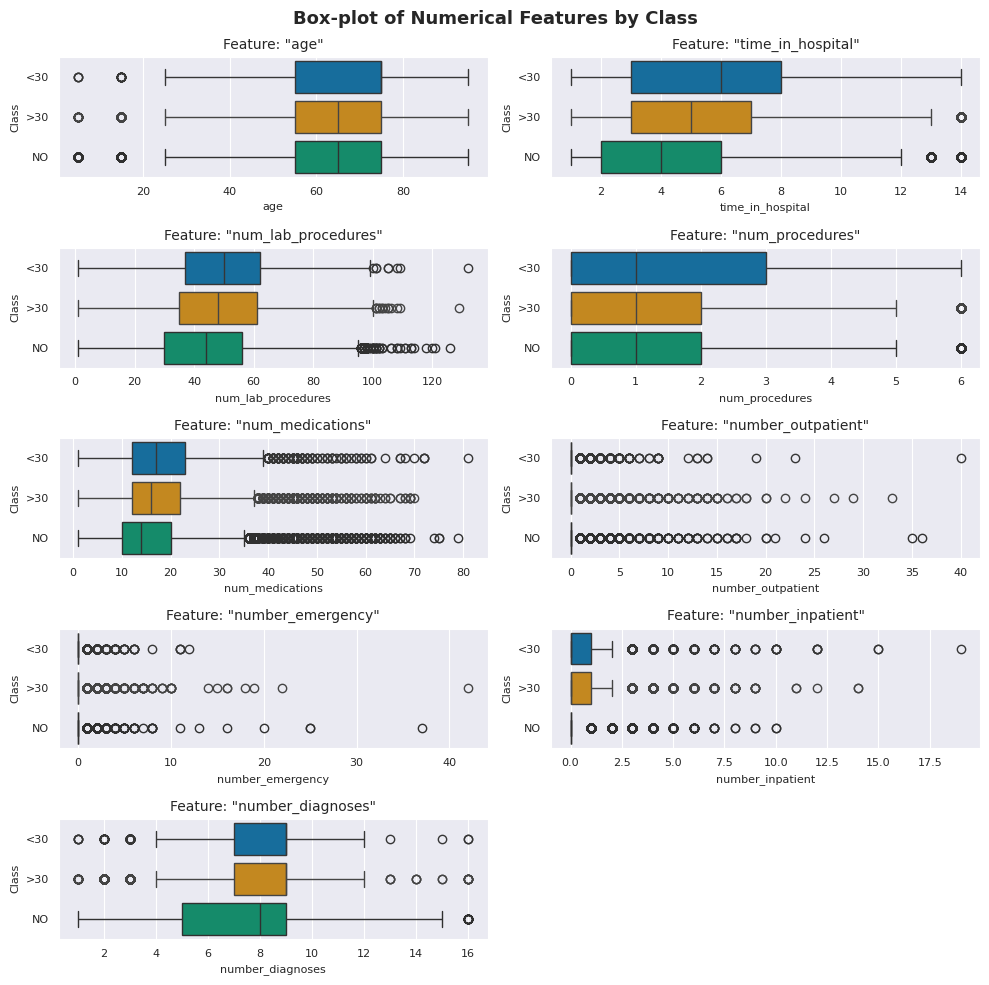

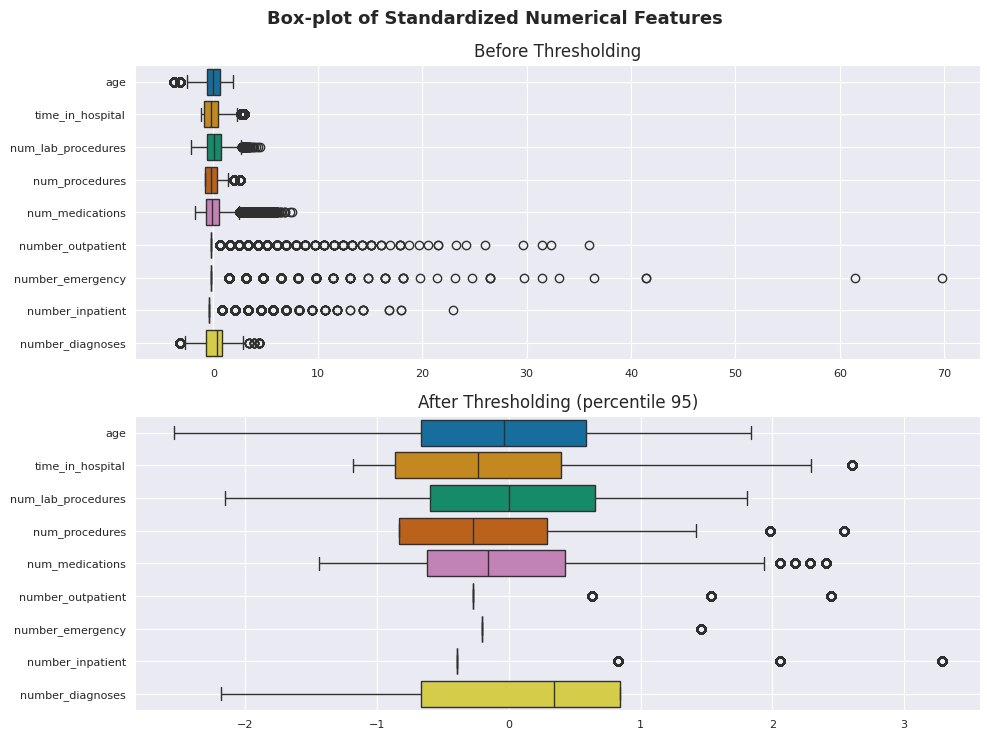

Outlier cells detected: 9950, which is  1.75% of the total numerical cells.


In [11]:
n_rows = math.ceil(len(feat_num)/2)

# Create boxplots comparing each numerical feature by class
plt.figure(figsize=(10, 2*n_rows))
plt.suptitle('Box-plot of Numerical Features by Class', fontsize=13, weight='bold')
sns.set_palette('colorblind')

for i, feat in enumerate(feat_num):
    plt.subplot(n_rows, 2, i + 1)
    for class_label in unique_classes:
        class_data = dataset_train.loc[dataset_train[output] == class_label, feat]
        sns.boxplot(y=[class_label]*len(class_data), x=class_data, orient= 'h')
    plt.title(f'Feature: "{feat}"', fontsize=10)
    plt.ylabel('Class', fontsize=8)
    plt.xlabel(feat, fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Detect outliers before thresholding
missing_before = dataset_train[feat_num].isnull().sum().sum()

# Normalize numerical features
scaler = StandardScaler()
features_num_norm = scaler.fit_transform(dataset_train[feat_num])
features_df_num_norm = pd.DataFrame(features_num_norm, columns=feat_num)

# Calculate the threshold percentile value and convert any outliers to NaN
percentile_threshold = 95
final_percentile = percentile_threshold+(100-percentile_threshold)/2
init_percentile = (100-percentile_threshold)/2

# Ignore NaNs in the calculation of percentiles
threshold_up = dataset_train[feat_num].apply(lambda x: np.percentile(x.dropna(), final_percentile))
threshold_down = dataset_train[feat_num].apply(lambda x: np.percentile(x.dropna(), init_percentile))

# Thresholding of data without affecting NaNs
dataset_train[feat_num] = dataset_train[feat_num].apply(
    lambda x: np.where((x >= threshold_down[x.name]) & (x <= threshold_up[x.name]), x, np.nan)
)

features_num_norm_thres = scaler.transform(dataset_train[feat_num])
features_df_num_norm_thres = pd.DataFrame(features_num_norm_thres, columns=feat_num)

fig, axs = plt.subplots(2, 1, figsize=(10, n_rows*1.5))

sns.boxplot(data=features_df_num_norm, orient= 'h', ax=axs[0])
axs[0].set_title('Before Thresholding', fontsize=12)
axs[0].tick_params(axis='both', labelsize=8)
axs[0].grid(True)

sns.boxplot(data=features_df_num_norm_thres, orient= 'h', ax=axs[1])
axs[1].set_title(f'After Thresholding (percentile {percentile_threshold})', fontsize=12)
axs[1].tick_params(axis='both', labelsize=8)
axs[1].grid(True)

fig.suptitle('Box-plot of Standardized Numerical Features', fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

# Number of cell outliers detected
missing_after = dataset_train[feat_num].isnull().sum().sum()
number_outliers = missing_after - missing_before
percentage_outliers = (number_outliers * 100) / dataset_train[feat_num].size
print(f'Outlier cells detected: {number_outliers}, which is {percentage_outliers: .2f}% of the total numerical cells.')

The next step is to impute missing data for those characteristics below the missing threshold. There are different methods for filling in missing values, depending on their origin. They are usually divided into three groups: missing completely at random (MCAR), missing at random (MAR) and missing not at random (MNAR). If we don't have any prior information, our advice is to assume the most common scenario, MNAR. This is the group we will be dealing with.

One of the most common approaches is to implement the Multivariate Imputation by Chained Equations (MICE) method [5]. This method offers a holistic imputation by employing multiple techniques to fill in the missing data and then combines the results to produce a final value. An unbiased imputation is paramount, correct imputation to the test set must be done with the imputator fitted with the training data.

In [12]:
# Train Linear Regression and KNN Imputers for numerical and categorical features respectively
numImputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)
catImputer = IterativeImputer(estimator=KNeighborsClassifier(), random_state=1, max_iter=10)

# Solve numerical missing
dataset_train[feat_num] = numImputer.fit_transform(dataset_train[feat_num])
dataset_test[feat_num] = numImputer.transform(dataset_test[feat_num])

# Solve categorical missing
ordinal_encoder = OrdinalEncoder()
features_cat_encoded = ordinal_encoder.fit_transform(dataset_train[feat_cat]) # Encode features
dataset_train[feat_cat] = catImputer.fit_transform(features_cat_encoded) # Impute values
dataset_train[feat_cat] = ordinal_encoder.inverse_transform(dataset_train[feat_cat]) # Decode features

features_cat_encoded = ordinal_encoder.transform(dataset_test[feat_cat]) 
dataset_test[feat_cat] = catImputer.transform(features_cat_encoded) 
dataset_test[feat_cat] = ordinal_encoder.inverse_transform(dataset_test[feat_cat])

To complete the data quality control stage, we will remove multivariate outliers. Our approach uses both PCA and Hotelling T2 techniques for numerical features. PCA helps determine the variation across different features, and the Hotelling T2 distribution provides the threshold to control outliers.

In [13]:
# Normalize numerical features and detect multivariate outliers
scaler = StandardScaler()
features_normalized = scaler.fit_transform(dataset_train[feat_num])
model_outliers = pca(alpha=0.01, detect_outliers=['ht2'])
results = model_outliers.fit_transform(features_normalized)

# Plot a random subset with outlier limits
random_idx = np.random.choice(dataset_train.shape[0], size=1000, replace=False)
dataset_sample = dataset_train.iloc[random_idx]
features_sample_normalized = scaler.transform(dataset_sample[feat_num])
model_outliers.fit_transform(features_sample_normalized)
outliers_sample = model_outliers.results['outliers']['y_bool']
outliers_coords = features_sample_normalized[outliers_sample]

# Save outliers for future use
outliers = results['outliers']['y_bool']
outliers_idx = dataset_train.index[outliers]
outliers_multivariate = dataset_train.loc[outliers_idx, :]
outliers_multivariate.to_csv(path + 'outliers_multivariate.csv', index=False)

print("\nNumber of outliers deleted:", len(outliers_idx))
dataset_train.drop(outliers_idx, inplace=True)

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [9] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.01] and n_components=[9]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Cleaning previous fitted model results..
[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


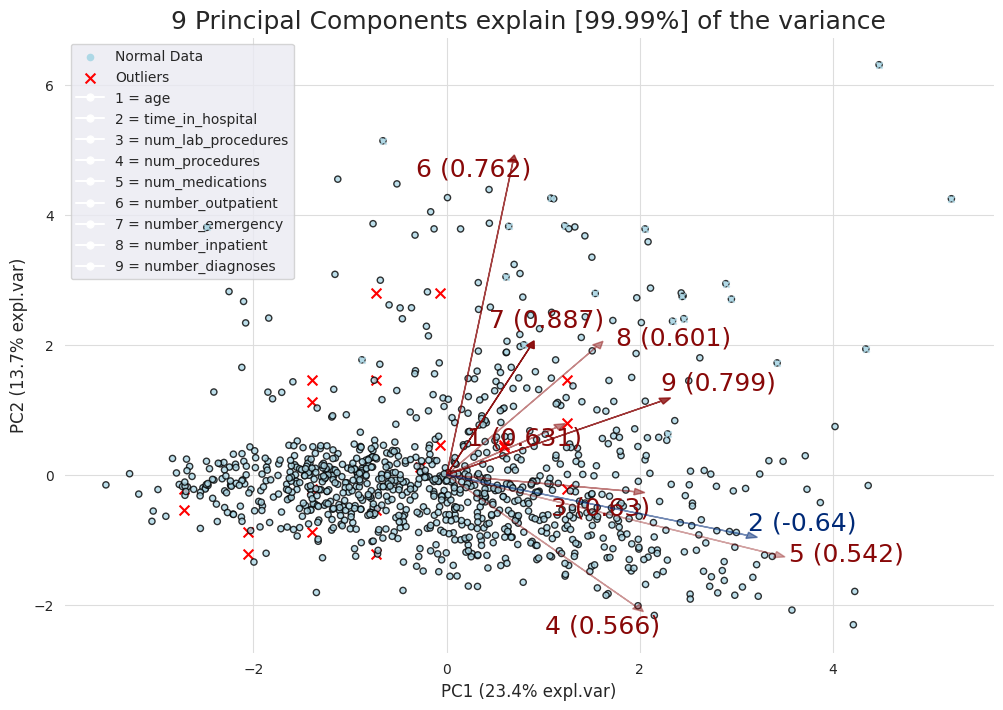

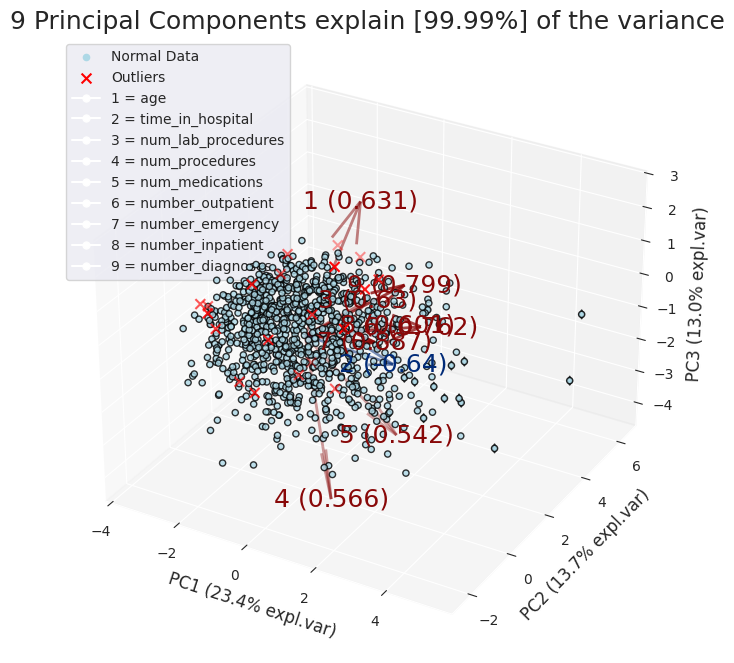

In [14]:
# 2D Biplot
fig, ax = plt.subplots(figsize=(12, 8))
model_outliers.biplot(legend=False, SPE=True, HT2=True, ax=ax)
for collection in ax.collections:
    try:
        collection.set_facecolor('lightblue')
        collection.set_sizes([20])
    except AttributeError:
        pass
ax.scatter([], [], color='lightblue', s=20, label='Normal Data')
ax.scatter(outliers_coords[:, 0], outliers_coords[:, 1], color='red', marker='x', s=50, label='Outliers')
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]
for i, feature in enumerate(feat_num):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'{i+1} = {feature}', markersize=5))
ax.legend(handles=handles, fontsize=10, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)

# 3D Biplot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
model_outliers.biplot3d(legend=False, SPE=True, HT2=True, ax=ax)
for collection in ax.collections:
    try:
        collection.set_facecolor('lightblue')
        collection.set_sizes([20])
    except AttributeError:
        pass
ax.scatter([], [], [], color='lightblue', s=20, label='Normal Data')
ax.scatter(outliers_coords[:, 0], outliers_coords[:, 1], outliers_coords[:, 2], color='red', marker='x', s=50, label='Outliers')
handles, labels = ax.get_legend_handles_labels()
handles = handles[1:]
labels = labels[1:]
for i, feature in enumerate(feat_num):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'{i+1} = {feature}', markersize=5))

ax.legend(handles=handles, fontsize=10, loc='upper left')
ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_xlabel(ax.get_xlabel(), fontsize=12)
ax.set_ylabel(ax.get_ylabel(), fontsize=12)
ax.set_zlabel(ax.get_zlabel(), fontsize=12)
plt.show() 

Since we do not have an acquisition date, we will perform an estimation based on a multidimensional projection of the features using PCA. Instances are grouped based on the direction of the feature with the higher variance with 10 intervals, 1 for each year between 1998-2008. 

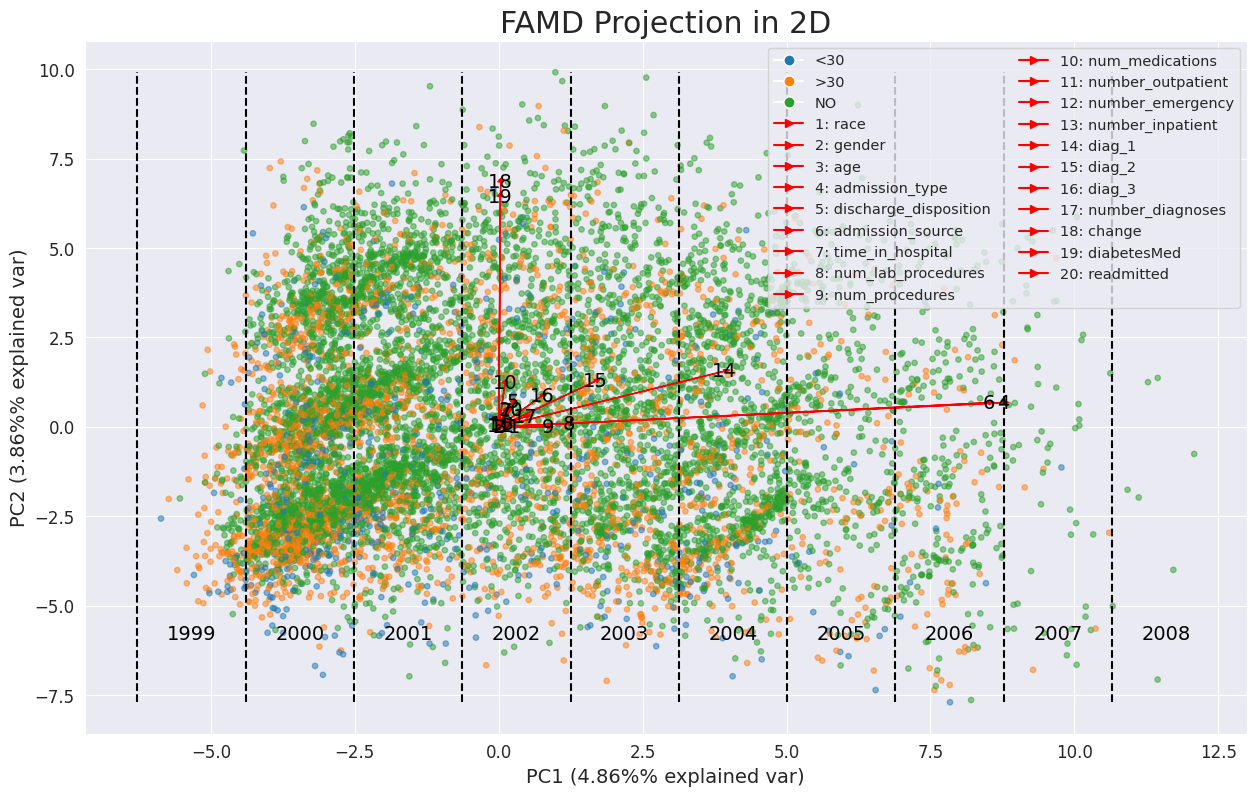

acquisition_date
1999     1196
2000    17791
2001    13852
2002     8241
2003     8411
2004     7281
2005     3066
2006     1993
2007      467
2008       82
Name: count, dtype: int64


In [15]:
dataset_train_FAMD = dataset_train.copy()

# Normalize numerical variables
scaler = StandardScaler()
dataset_train_FAMD[feat_num] = scaler.fit_transform(dataset_train_FAMD[feat_num])

famd = prince.FAMD(
    n_components=2,
    n_iter=3,
    check_input=True,
    random_state=42,
    engine="sklearn",
    handle_unknown="error"
)

dataset_train_FAMD_transformed = famd.fit_transform(dataset_train_FAMD)
transformed_with_tags = pd.concat([pd.DataFrame(dataset_train_FAMD_transformed), dataset_train[output]], axis=1)

subsample = transformed_with_tags.sample(n=10000, random_state=1)
x_component = subsample[0]
y_component = subsample[1]
eigenvalues_summary_df = pd.DataFrame(famd.eigenvalues_summary)

# Define colors for each class
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'purple', 'brown', 'pink', 'gray']
color_dict = {cls: colors[i % len(colors)] for i, cls in enumerate(unique_classes)}

# Plotting 2D scatter plot
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111)

scatter = ax.scatter(x_component, y_component, c=subsample.iloc[:, 2].map(color_dict), marker='o', s=15, alpha=0.5)
ax.set_xlabel(f'PC1 ({eigenvalues_summary_df.iloc[0, 1]}% explained var)')
ax.set_ylabel(f'PC2 ({eigenvalues_summary_df.iloc[1, 1]}% explained var)')
ax.set_title('FAMD Projection in 2D')

# Custom legend
legend_elements = [Line2D([0], [0], marker='o', color='w', label=cls, markerfacecolor=color_dict[cls], markersize=8) for cls in unique_classes]
for i, feature in enumerate(dataset_train.columns):
    legend_elements.append(Line2D([0], [0], marker='>', color='red', label=f'{i+1}: {feature}', markersize=6))

# Project feature vectors onto the 2D plot
scale_factor = 12
for i, feature in enumerate(dataset_train.columns):
    ax.arrow(0, 0,
             famd.column_coordinates_.loc[feature, 0] * scale_factor,
             famd.column_coordinates_.loc[feature, 1] * scale_factor,
             color='red', head_width=0.1, head_length=0.1)
    ax.text(famd.column_coordinates_.loc[feature, 0] * scale_factor,
            famd.column_coordinates_.loc[feature, 1] * scale_factor,
            f'{i+1}', color='black', fontsize=14, ha='center', va='center')

ax.legend(handles=legend_elements, loc='upper right', fontsize='xx-small', ncol=2)

pc1 = dataset_train_FAMD_transformed.iloc[:, 0]
bins = np.linspace(min(pc1), max(pc1), 11) # Divide PC1 into 10 equal parts
years = list(range(1999, 2009)) # Years corresponding to each interval (1999 - 2008)


# Create new column 'acquisition_date' based on PC1 intervals
dataset_train_FAMD['acquisition_date'] = pd.cut(pc1, bins=bins, labels=years, include_lowest=True).astype(int)

# Add vertical lines at the division points defined by bins
for i in range(len(bins)-1):
    bin_edge = bins[i]
    year = years[i]
    ax.vlines(bin_edge, ymin=min(y_component), ymax=max(y_component), color='black', linestyle='--')
    ax.text(bin_edge + (bins[i+1] - bins[i]) / 2, min(y_component) + 0.1 * (max(y_component) - min(y_component)), str(year), color='black', ha='center', fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(ax.get_xlabel(), fontsize=14)
ax.set_ylabel(ax.get_ylabel(), fontsize=14)
plt.show()

print(dataset_train_FAMD['acquisition_date'].value_counts().sort_index())


At this point, it is possible to use data in a more proper way and make more accurate analyses.

In [16]:
file_name_train = 'dataset_train_QC.csv'
dataset_train.to_csv(path + file_name_train, index=False)

file_name_test = 'dataset_test_QC.csv'
dataset_test.to_csv(path + file_name_test, index=False)

print(f"The data frames are saved as '{file_name_train}' and '{file_name_test}'.")

file_name = 'metadata_QC.json'

# Save metadata to a JSON file at the specified path
with open(path + file_name, 'w') as json_file:
    json.dump(metadata, json_file, indent=4)

print(f"The Metadata has been saved to {file_name}.")

file_name_shift = 'dataset_shift.csv'
dataset_train_FAMD.to_csv(path + file_name_shift, index=False)
print(f"The dataset with temporal information has been saved to '{file_name_shift}'.")


The data frames are saved as 'dataset_train_QC.csv' and 'dataset_test_QC.csv'.
The Metadata has been saved to metadata_QC.json.
The dataset with temporal information has been saved to 'dataset_shift.csv'.


For our particular experiment, we assume that access is restricted to the author, so the `access protocols` do not apply. However, in the case of multiple developers, such as a company, it would be necessary to consider them.

## REFERENCES  <a class="anchor" id="references"></a>

1. Olatunji, I. E., Rauch, J., Katzensteiner, M., & Khosla, M. (2022). A Review of Anonymization for Healthcare Data. Big Data, big.2021.0169. https://doi.org/10.1089/big.2021.0169 <br>

2. Health, Ministry of. Diagnostic Code Descriptions (ICD-9) - Province of British Columbia. https://www2.gov.bc.ca/gov/content/health/practitioner-professional-resources/msp/physicians/diagnostic-code-descriptions-icd-9. Accessed 14 Mar. 2024.<br>

3. Strack, Beata, et al. ‘Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records’. BioMed Research International, vol. 2014, 2014, p. 781670. PubMed, https://doi.org/10.1155/2014/781670.<br>

4. Sáez C, Martínez-Miranda J, Robles M, García-Gómez JM. Organizing data quality assessment of shifting biomedical data. Stud Health Technol Inform. 2012;180:721-5. PMID: 22874286. https://pubmed.ncbi.nlm.nih.gov/22874286/<br>

5. Stavseth, Marianne Riksheim, et al. ‘How Handling Missing Data May Impact Conclusions: A Comparison of Six Different Imputation Methods for Categorical Questionnaire Data’. SAGE Open Medicine, vol. 7, Jan. 2019, p. 205031211882291. DOI.org (Crossref), https://doi.org/10.1177/2050312118822912.<br>



&copy; 2024 Carlos de Manuel & Carlos Sáez - Universitat Politècnica de València 2024
